**Taller #2**

**Nota:** El archivo esta hecho para correrse de manera secuencial, debido a que las celdas utilizan funcionas y variables de celdas anteriores. Para correcto funcionamiento, correr todas las celdas anteriores a la que se desee probar.

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from PIL import Image
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import binary_dilation

Punto 1

In [2]:
#CARGA DE DATOS

dict_data = {"year":[], "month":[], "day":[], "SSN":[]}
counter = 0
temp_list = None

with open("list_aavso-arssn_daily.txt") as data:
    while True:
        line = data.readline()
        if counter > 1:
            temp_list = line.split()
            dict_data["year"].append(float(temp_list[0]))
            dict_data["month"].append(float(temp_list[1]))
            dict_data["day"].append(float(temp_list[2]))
            dict_data["SSN"].append(float(temp_list[3]))
        if temp_list == ['2012', '1', '1', '39']:
            break
        counter += 1

*1.1*

In [3]:
#Creando un nuevo diccionario sin SSN:
datos_fechas = dict_data.copy()
datos_fechas.pop("SSN")

#Pasando al formato to_datetime
formated_data = pd.to_datetime(datos_fechas)

#Sacando la transformada de Fourier
transformada = np.fft.fft(dict_data["SSN"] - np.mean((dict_data)["SSN"]))

#Sacando la cantidad de muestras por año a travez de la moda de las muestras
anios = {}
for i in dict_data["year"]:
    if str(i) not in anios:
        anios[f"{i}"] = dict_data["year"].count(i)
sample_frecuency = stats.mode([anios[x] for x in anios.keys()])[0]

#Sacando la frecuencia del sistema
freq = np.fft.fftfreq(len(dict_data["SSN"]), d=1/sample_frecuency)
magnitudes = np.abs(transformada)
freq_positivas = freq[:len(freq) // 2]
magnitudes_positivas = magnitudes[:len(magnitudes) // 2]
frecuencia_principal = freq_positivas[list(magnitudes_positivas).index(np.max(magnitudes_positivas))]

print(f"El periodo de la señal es de: {round(1/frecuencia_principal, 2)} años")

El periodo de la señal es de: 11.17 años


*1.2*

c:\Users\PEPE\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PEPE\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


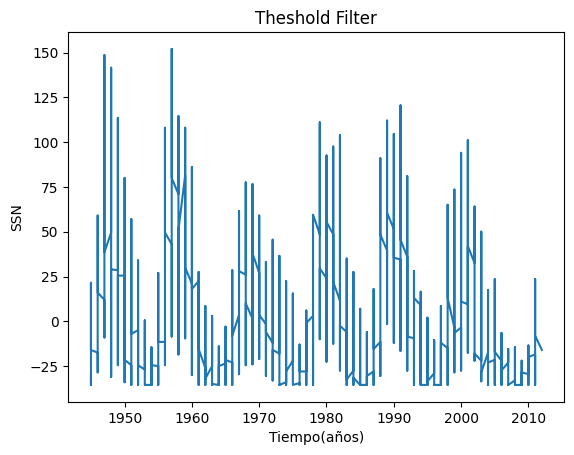

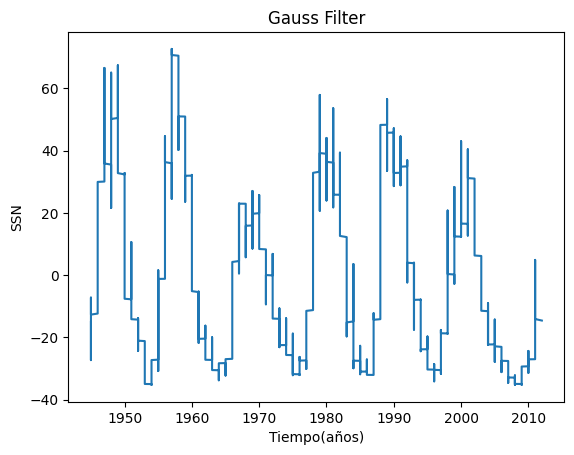

Claramente, el filtro de Gauss es mucho mejor para este caso, puesto que el tipo Threshold nos da un resultado con transiciones muy abruptas, lo que hace que se pierda el sentido físico de los datos a la vista.


In [4]:
#Utilizando los resultados del ejercicio anterior:

#Filtro threshold
freq_corte = frecuencia_principal
filtro = transformada
filtro[np.abs(freq) > freq] = 0
senal_filtrada = np.fft.ifft(filtro)

#Filtro Gauss
gamma = freq_corte / np.sqrt(2*np.log(2))
filtro_gauss = np.exp(-(freq**2)*(gamma))
senal_filtrada_gauss = np.fft.ifft(transformada * filtro_gauss)

plt.plot(dict_data["year"], senal_filtrada)
plt.title("Theshold Filter")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()
plt.plot(dict_data["year"], senal_filtrada_gauss)
plt.title("Gauss Filter")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()
print("Claramente, el filtro de Gauss es mucho mejor para este caso, puesto que el tipo Threshold nos da un resultado con transiciones muy abruptas, lo que hace que se pierda el sentido físico de los datos a la vista.")

C:\Users\PEPE\AppData\Local\Temp\ipykernel_28908\769273655.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( np.log10(freq_positivas), np.log10(magnitudes_positivas))


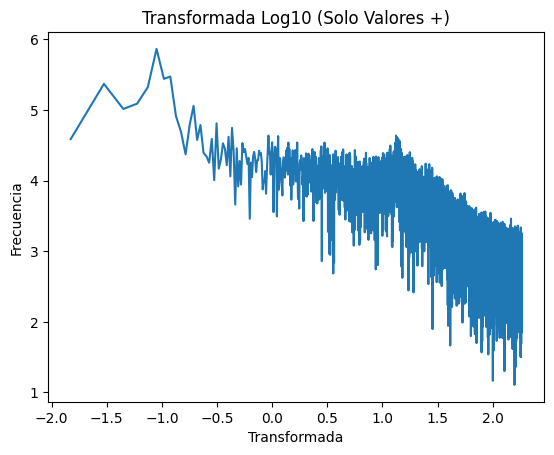

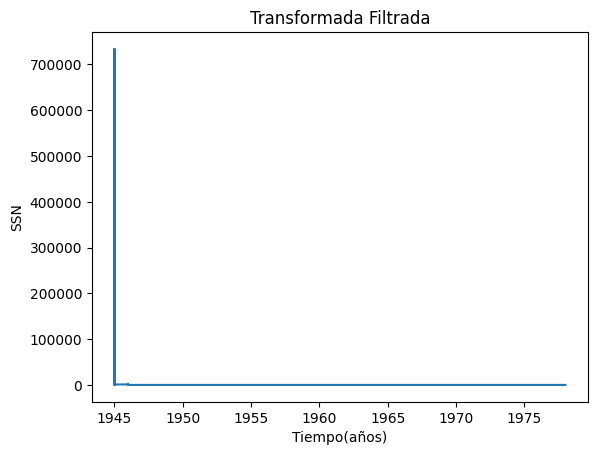

In [5]:
#1.2 a)
plt.plot( np.log10(freq_positivas), np.log10(magnitudes_positivas))
plt.title("Transformada Log10 (Solo Valores +)")
plt.xlabel("Transformada")
plt.ylabel("Frecuencia")
plt.show()
plt.plot(dict_data["year"][:len(dict_data["year"]) // 2], (magnitudes_positivas * filtro_gauss[:len(freq) // 2]))
plt.title("Transformada Filtrada")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()

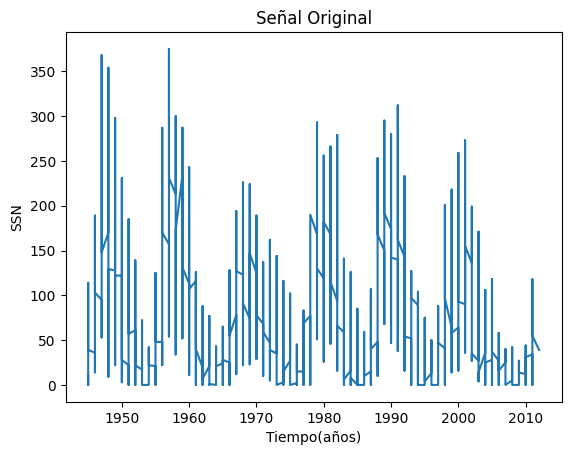

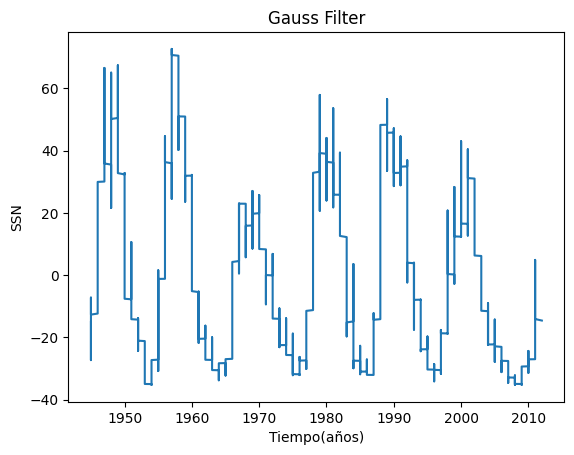

In [6]:
#1.2 b)
#Ya este paso lo habia hecho en el punto 1.2 asi que solo referenciare los resultados:

plt.plot(dict_data["year"], dict_data["SSN"])
plt.title("Señal Original")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()
plt.plot(dict_data["year"], senal_filtrada_gauss)
plt.title("Gauss Filter")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()

*1.3*

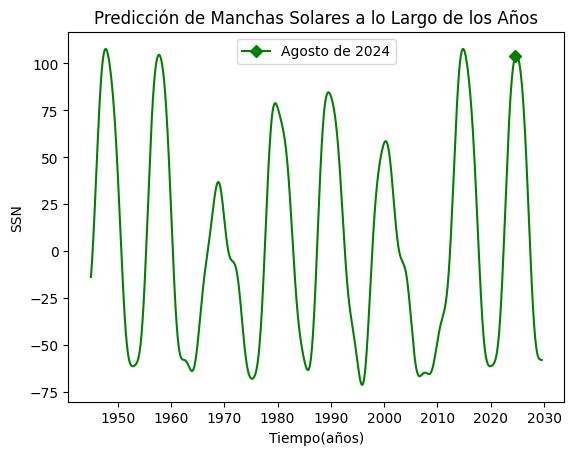

Como se oberva en la gráfica, en agosto del 2024 estamos en un pico de la actividad solar.
En el mes de agosto del 2024, se espera observar 103.8 manchas solares. Este numero esta bastante cerca al numero predicho por fuentes oficiales, que está alrededor de 100.


In [105]:
#Encontrando los valores mas grande de la transformada:

indices_valores_grandes_reverso = np.argsort(magnitudes_positivas)
indices_valores_grandes = indices_valores_grandes_reverso[::-1]

#Sacamos los valores de la frecuencia, magnitud y la fase en sus indices correpondientes:

freq_armonicos = freq_positivas[indices_valores_grandes[:10]]
magni_armonicos = magnitudes_positivas[indices_valores_grandes[:10]]
fase_armonicos = np.angle(transformada[indices_valores_grandes[:10]])

def formula(f, m, ph, t):
    lista_gen = []
    for j in t:
        func_generatriz = 0
        for i in range(10):
            func_generatriz += m[i]*np.cos(2*np.pi*j*f[i]+ph[i])
        lista_gen.append(func_generatriz)
    return lista_gen

anio_goal = 2024.58
anios_totales = anio_goal - 1945 + 5
tiempo_test = np.linspace(0, anios_totales, 10000) + 1945
prediccion = formula(freq_armonicos, magni_armonicos, fase_armonicos, tiempo_test)

#Encontrando el indice del periodo de tiempo buscando en el array:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(tiempo_test, anio_goal)

for i in range(len(prediccion)):
    prediccion[i] /= len(magnitudes_positivas)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.plot(tiempo_test, prediccion, '-gD', markevery = [idx], label='Agosto de 2024')
plt.legend()
plt.title("Predicción de Manchas Solares a lo Largo de los Años")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()

print("Como se oberva en la gráfica, en agosto del 2024 estamos en un pico de la actividad solar.")
print(f"En el mes de agosto del 2024, se espera observar {round(prediccion[idx],1)} manchas solares. Este numero esta bastante cerca al numero predicho por fuentes oficiales, que está alrededor de 100.")

Punto 2

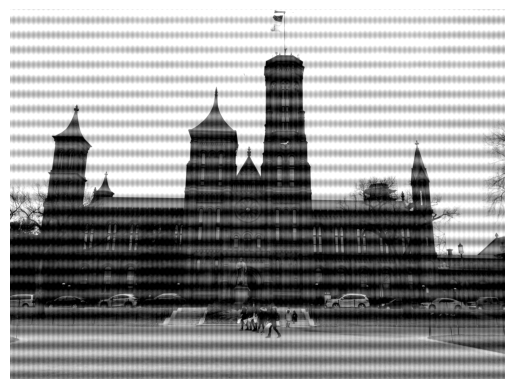

In [254]:
#Importando y mostrando la imagen

img = np.array(Image.open("Noisy_Smithsonian_Castle.jpg")).astype(float)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

*2.1*

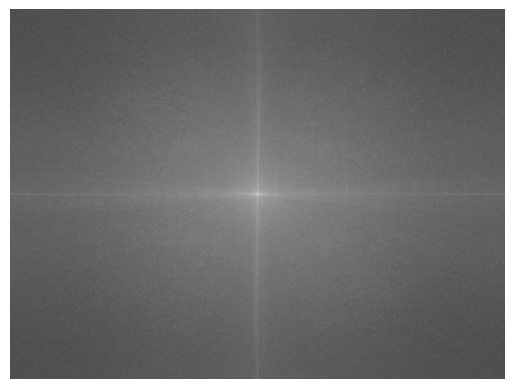

In [255]:
#Calcular la transformada del array:

transformada_imagen = np.fft.fft2(img)
centrada = np.fft.fftshift(transformada_imagen)
magnitud_imagen = np.abs(centrada)

plt.imshow(np.log(1 + magnitud_imagen), cmap="gray")
plt.axis("off")
plt.show()

*2.2*

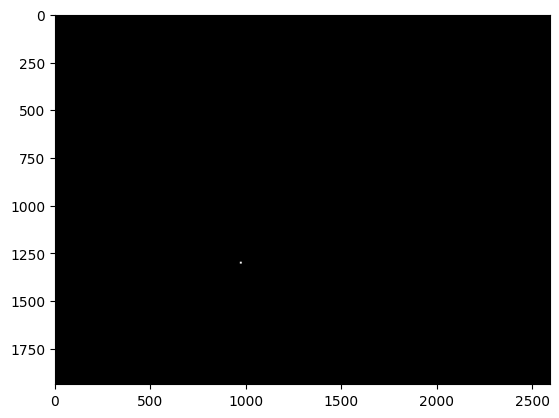

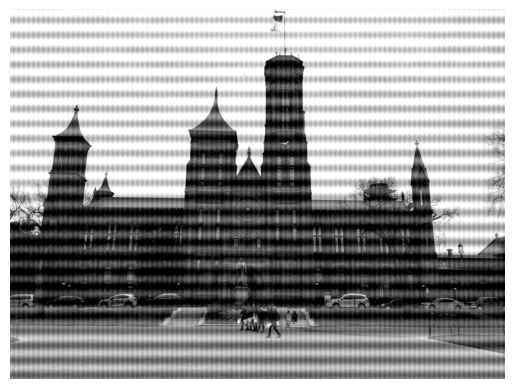

In [256]:
#Calculamos el valor sobre el cual vamos a encerar la transformada:

valor_corte = np.max(magnitud_imagen) * 0.6
#Encerando los valores por encima del corte:
centrada2 = centrada
a = np.zeros_like(magnitud_imagen)

counter1, counter2 = 0, 0
for i in magnitud_imagen:
    for j in i:
        if j > valor_corte:
            #centrada2[counter1-5:counter1+5][counter2-5:counter2-5] = 0
            centrada2[counter2:counter2+10,counter1:counter1+10] = 0
            a[counter2:counter2+10,counter1:counter1+10] = 1
        counter2 += 1
    counter2 = 0
    counter1 += 1

#Invertir la transformada:

no_centrada = np.fft.ifftshift(centrada2)
inversa_t_imagen = np.fft.ifft2(no_centrada)
inversa_final = np.abs(inversa_t_imagen)

#Graficar:

plt.imshow(a, cmap="gray")
plt.show()

plt.imshow(inversa_final, cmap='gray')
plt.axis("off")
plt.show()
